------------------------
**EXECUTION SETUP**

In [1]:
# MAIN EXECUTION PARAMETERS
unit_check = False # turns off optimization but allows to use astropy to check the units
opt_tf = True # use tensorflow instead of numpy for GPU acceleration, x5 speedup
opt_numba = True # use numba to pre-compile some of the functions, about 3x speedup (turned off if opt_tf is on and GPU available)
convert_vtk = True # saves vtk and processing data as pkl -- needed to use tensorflow, but also prevents from recalculating the same data
force_recalc = True # force recalculation of augmented data, even if present in the pkl files
#---------------------------------------------------------------

# optimization logic
opt_tf = (not unit_check and opt_tf)
if opt_tf:
    import tensorflow as tf
    gpu_list = tf.config.list_physical_devices('GPU')
    # do not use tensorflow if no GPU detected, use numba instead
    opt_tf = (len(gpu_list) > 0)

opt_numba = (not unit_check and not opt_tf and opt_numba)
opt_fastmath = (opt_numba and True) # 20% speedup, but less precision

# general imports
import glob
import os
from tqdm import tqdm
import numpy as np
import pickle as pkl
from collections.abc import Iterable
from numba import jit, prange

# vtk file loading if available
try:
    import vtk as _
    from read_vtk import vtk
except ImportError:
    def vtk(x, out_dt):
        print('VTK module not available. Please convert to pkl files and use those instead.', flush=True)
        import sys; sys.exit()

In [2]:
# tensorflow optimization wrappers
if opt_tf:
    print("Tensorflow %s" % tf.__version__)
    print(gpu_list)
    def tf_convert (*arg):
        '''Convert all arguments to tf.const for GPU processing'''
        return (tf.convert_to_tensor(x, dtype='float64') for x in arg)
    def tf_deconvert (x):
        '''Use tensor.to_numpy() to perform tf operations'''
        return x.numpy()
    where = tf.where
    exp = tf.math.exp
    linspace = tf.linspace
    meshgrid = tf.meshgrid
    npsum = tf.math.reduce_sum
    log = tf.math.log
    reshape = tf.reshape
    sqrt = tf.math.sqrt
    def logspace (xmin,xmax,n):
        return 10.**tf.linspace(xmin,xmax,n)
    def log10 (x):
        ten, = tf_convert(10.)
        return tf.math.log(x) / tf.math.log(ten)
    def nansum (x, axis):
        return tf.math.reduce_sum(tf.where(tf.math.is_nan(x),tf.zeros_like(x),x), axis=axis)
else:
    @jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
    def tf_convert (*arg):
        return arg
    @jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
    def tf_deconvert (arg):
        return arg
    where = np.where
    exp = np.exp
    linspace = np.linspace
    meshgrid = np.meshgrid
    npsum = np.sum
    log = np.log
    reshape = np.reshape
    sqrt = np.sqrt
    logspace = np.logspace
    log10 = np.log10
    nansum = np.nansum

Tensorflow 2.1.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# constants
from astropy.constants import e, c, m_e
import astropy.units as u
from scipy.special import gamma
e = e.esu.value * u.cm**1.5 * u.g**0.5 / u.s

if unit_check:
    #units
    cm = u.cm
    sec = u.s
    Hz = u.Hz
    kpc = u.kpc
    Msun = u.Msun
    erg = u.erg
    def get_cgs (x): return x.cgs
    def get_cgs_value (x): return x.cgs.value
else:
    #constants
    e = e.cgs.value
    c = c.cgs.value
    m_e = m_e.cgs.value
    #units
    cm = 1.0
    sec = 1.0
    Hz = 1.0
    kpc = (1.*u.kpc).cgs.value
    Msun = (1.*u.Msun).cgs.value
    erg = (1.*u.erg).cgs.value
    @jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
    def get_cgs (x): return x
    @jit(nopython=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
    def get_cgs_value (x): return x

--------------------
**PHYSICS**

In [4]:
# read the file list
datapath = '/DATA/Dropbox/LOOTRPV/astro_projects/2020_IntSh2/athena4p2/bin_paper1/test1_bfield/'
outpath = './temp_dashboard/'
if not os.path.exists(outpath):
    os.makedirs(outpath)
    
out_dt_vtk = 0.1
adiab_idx = 1.33333333333

vtk_filenames = sorted(glob.glob(datapath + 'joined_vtk/*.vtk'))

In [5]:
# sychrotron emission treatment
#TODO: change parameters to typical from Malzac models
gmin = 1.0e2
gmax = 1.0e6
p = 2.5
xi_e = 0.5 # electron equipartition parameter, U_e = xi_e* U_B

# choice of emitting region size and frequency for plotting
R_choice = 1.5e10 * cm # ~ 10^4rg, see Shidatsu et al. (2011)
nu_choice = 1.4e15 * Hz # see Malzac et al. (2018)

# system properties (see overleaf)
beta_jet = 0.75
gamma_jet = 2.0
incl = 23.0 * np.pi / 180.
theta_j = 2.3 * np.pi / 180.
dist = 8. * kpc
mbh = 10. * Msun

# See Malzac (2014), appendix A

if p != 2.0:
    gamma_e_bar = (1-p)/(2-p) * (gmax**(2-p) - gmin**(2-p)) / (gmax**(1-p) - gmin**(1-p))
else:
    gamma_e_bar = (1-p) * np.log(gmax/gmin) / (gmax**(1-p) - gmin**(1-p))

i_gamma = ( gamma_e_bar * (1/(1-p)) * (gmax**(1-p) - gmin**(1-p)) )**(-1)

K_j = ( (np.sqrt(3.) * e**3 * i_gamma) / (16*np.pi**2 * m_e**2 * c**4 * (p+1)) ) \
    * gamma((3*p+19)/12.) * gamma((3*p-1)/12.) * (m_e*c/(3*e))**(-(p-1)/2.)
    
K_a = ( (np.sqrt(3.) * e**3 * i_gamma) / (64*np.pi**2 * m_e**3 * c**4) ) \
    * (3.*e / (2.*np.pi*m_e*c))**(0.5*p) \
    * gamma((3.*p+2)/12.) * gamma((3.*p+22)/12.)
    
# j_nu, nu in fluid frame
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def j_nu (nu_fl, B):
    nu_fl, B = tf_convert(nu_fl, B)
    return get_cgs(K_j * xi_e * (B*(erg/cm**3)**0.5)**((p+5)/2.) * (nu_fl*Hz)**(-(p-1)/2.))
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def alpha_nu (nu_fl, B):
    nu_fl, B = tf_convert(nu_fl, B)
    return get_cgs(K_a * xi_e * (B*(erg/cm**3)**0.5)**(0.5*p+3) * (nu_fl*Hz)**(-(p+4)/2.))
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def j_over_alpha_nu (nu_fl, B):
    nu_fl, B = tf_convert(nu_fl, B)
    return get_cgs((K_j/K_a) * (B*(erg/cm**3)**0.5)**(-0.5) * (nu_fl*Hz)**(2.5))
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def intensity (nu_fl, B, R):
    nu_fl, B, R = tf_convert(nu_fl, B, R)
    # for small alphae, we need to use a Taylor expansion
    alpha = alpha_nu(nu_fl,B)
    return where(
        alpha*R*cm < 1.0e-6,
        j_nu(nu_fl, B) * R*cm,
        j_over_alpha_nu(nu_fl, B) * (1.0-exp(-alpha*R*cm))
    )
    
# observables
doppler_factor = 1.0 / (gamma_jet*(1.0-beta_jet*np.cos(incl)))
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def nu2nu_fl (nu):
    return nu/doppler_factor
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def flux_nu (nu, B, R, dS, filling_factor=1.0):
    nu, B, R, dS, filling_factor = tf_convert(nu, B, R, dS, filling_factor)
    return (doppler_factor**2 * gamma_jet / (2.*dist**2)) \
             * filling_factor* intensity(nu/doppler_factor,B,R) \
             * (dS*cm**2) # perp. surface element, instead of (beta c dt R)
# total flux within the IR-opt range: 300GHz - 3PHz
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def _flux_total_integrate (nu_grid,B_grid,R,dS, dlognu_grid):
    nu_grid,B_grid,R,dS, dlognu_grid = tf_convert(nu_grid,B_grid,R,dS, dlognu_grid)
    integrand = nu_grid*Hz * get_cgs(flux_nu(nu_grid,B_grid,R,dS))
    return npsum(integrand*dlognu_grid, axis=-1)
# Do NOT use numba for flux_total. It does not understand np.meshgrid, and alternative implementations cause the code to be extremely slow.
def flux_total (B,R,dS, nu_min=300.0e9, nu_max=3.0e15, resolution=1024):
    B,R,dS, nu_min, nu_max = tf_convert(B,R,dS, nu_min, nu_max)
    Bshape = B.shape
    # log-integrate the flux
    lognu = linspace(log(nu_min), log(nu_max), resolution)
    dlognu = lognu[1:] - lognu[:-1]
    lognu = 0.5 * (lognu[1:] + lognu[:-1])
    nu = exp(lognu)
    B_grid, nu_grid = meshgrid(B, nu, indexing='ij')
    B_grid, dlognu_grid = meshgrid(B, dlognu, indexing='ij')
    return get_cgs(reshape(_flux_total_integrate(nu_grid,B_grid,R,dS, dlognu_grid), Bshape))

In [6]:
%timeit j_nu(12., 12.)

886 µs ± 287 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
print(j_nu(12., 12.))
print(alpha_nu(12., 12.))
print(intensity(12., 12.,12.))
print(flux_total(np.array([12.,]),12.,0.5))
if unit_check:
    print("Check that dimensionless: ", get_cgs(j_over_alpha_nu(12., 12.) / (erg / (cm**2))),
      get_cgs(flux_total(np.array([12.,]),12.,0.5)) / get_cgs(erg/(cm**2*sec)))

tf.Tensor(2.540471985544854e-09, shape=(), dtype=float64)
tf.Tensor(1.0334232545911243e+19, shape=(), dtype=float64)
tf.Tensor(2.45830735302158e-28, shape=(), dtype=float64)
tf.Tensor([1.6052244e-47], shape=(1,), dtype=float64)


In [8]:
# other frequently used functions, moved here to enable numba optimization

# vector operations
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def sqr_vec_l2 (x,y,z):
    x,y,z = tf_convert(x,y,z)
    return x**2 + y**2 + z**2
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def norm_vec_l2 (x,y,z):
    x,y,z = tf_convert(x,y,z)
    return sqrt(x**2 + y**2 + z**2)

# SR operations
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def v2gamma (v):
    v, = tf_convert(v)
    return 1.0/sqrt(1.0-v**2)
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def vsqr2gamma (vsqr):
    vsqr, = tf_convert(vsqr)
    return 1.0/sqrt(1.0-vsqr)

# Bcc in the fluid frame
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def BccFl0 (gamma, v1,v2,v3, b1,b2,b3):
    gamma, v1,v2,v3, b1,b2,b3 = tf_convert(gamma, v1,v2,v3, b1,b2,b3)
    return gamma * (v1*b1 + v2*b2 + v3*b3)
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def BccFli (gamma, v,b, bFl0):
    gamma, v,b, bFl0 = tf_convert(gamma, v,b, bFl0)
    return b / gamma + bFl0 * v

# plasma parameters
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def plasma_beta (press, Bflsqr):
    press, Bflsqr = tf_convert(press, Bflsqr)
    return 2.*press / Bflsqr
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def magnetization (Bflsqr, rho):
    Bflsqr, rho = tf_convert(Bflsqr, rho)
    return Bflsqr / rho

# internal energy in the fluid frame, see Beckwith & Stone (2011)
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def enthalpy (adiab_idx, press, rho):
    adiab_idx, press, rho = tf_convert(adiab_idx, press, rho)
    return 1.0 + ((adiab_idx)/(adiab_idx-1.0)) * press / rho
@jit(nopython=opt_numba, parallel=opt_numba, fastmath=opt_fastmath, forceobj=(not opt_numba))
def internal_energy (rho, enthalpy, gamma, press, Bflsqr):
    rho, enthalpy, gamma, press, Bflsqr = tf_convert(rho, enthalpy, gamma, press, Bflsqr)
    return rho * enthalpy * gamma**2 - press + 0.5 * Bflsqr # warning!: includes rest mass

In [9]:
def do_vertical_avg (data_vtk, quantity):
    yrange = (data_vtk['x2v'][1] - data_vtk['x2v'][0]) * len(data_vtk['x2v'])
    data_vtk[quantity+'_vsZ'] = tf_deconvert(npsum(data_vtk[quantity], axis=0) / yrange)
    
default_augment_kwargs = {
    'nu_res':128, 'nu_min':1., 'nu_max':3.0e15,
    'nu_int_min':300.0e9, 'nu_int_max':3.0e15,
    'R_selection':6.0e8, 'nu_selection':1.4e15, 'filling_factor':1.0
}

def augment_vtk_data (data_vtk, previous_data_vtk=None, 
                      nu_res=128, nu_min=1., nu_max=3.0e15,
                      nu_int_min=300.0e9, nu_int_max=3.0e15,
                      R_selection=6.0e8, nu_selection=1.4e15, filling_factor=1.0):
    
    ''' calculate auxiliary data '''
    
    yrange = (data_vtk['x2v'][1] - data_vtk['x2v'][0]) * len(data_vtk['x2v'])
    
    # SR quantities
    # NOTE: in Athena 4.2 vel1, vel2, vel3 are 3-velocities. Instead Athena++ uses 4-velocities in the code (so they would need to be translated).
    vel_tot_sqr = sqr_vec_l2(data_vtk['vel1'], data_vtk['vel2'], data_vtk['vel3'])
    data_vtk['vel_tot'] = tf_deconvert(sqrt(vel_tot_sqr))
    gam = vsqr2gamma(vel_tot_sqr)
    data_vtk['gamma'] = tf_deconvert(gam)
    del vel_tot_sqr

    # total Bcc in observer frame
    data_vtk['Bcc_tot'] = tf_deconvert(sqr_vec_l2(data_vtk['Bcc1'], data_vtk['Bcc2'], data_vtk['Bcc3']))

    # Bcc in the fluid frame
    Bfl0 = BccFl0(
        gam,
        data_vtk['vel1'],data_vtk['vel2'],data_vtk['vel3'],
        data_vtk['Bcc1'],data_vtk['Bcc2'],data_vtk['Bcc3'],
    )
    Bfl1 = BccFli(
        gam, 
        data_vtk['vel1'], data_vtk['Bcc1'],
        Bfl0
    )
    Bfl2 = BccFli(
        gam, 
        data_vtk['vel2'], data_vtk['Bcc2'],
        Bfl0
    )
    Bfl3 = BccFli(
        gam, 
        data_vtk['vel3'], data_vtk['Bcc3'],
        Bfl0
    )
    Bcc_fluid_tot_sqr = sqr_vec_l2(Bfl1, Bfl2, Bfl3)
    Bcc_fluid_tot = sqrt(Bcc_fluid_tot_sqr)
    data_vtk['Bcc_fluid_0'] = tf_deconvert(Bfl0)
    data_vtk['Bcc_fluid_1'] = tf_deconvert(Bfl1)
    data_vtk['Bcc_fluid_2'] = tf_deconvert(Bfl2)
    data_vtk['Bcc_fluid_3'] = tf_deconvert(Bfl3)
    data_vtk['Bcc_fluid_tot'] = tf_deconvert(Bcc_fluid_tot)
    do_vertical_avg(data_vtk, 'Bcc_fluid_tot')

    # plasma parameters
    data_vtk['plasma_beta'] = tf_deconvert(plasma_beta(data_vtk['press'], Bcc_fluid_tot_sqr))
    data_vtk['magnetization'] = tf_deconvert(magnetization(Bcc_fluid_tot_sqr, data_vtk['rho']))
    
    # internal energy in the fluid frame, see Beckwith & Stone (2011)
    enth = enthalpy(adiab_idx, data_vtk['press'], data_vtk['rho'])
    data_vtk['enthalpy'] = tf_deconvert(enth)
    data_vtk['internal_energy'] = tf_deconvert(internal_energy(data_vtk['rho'], enth, gam, data_vtk['press'], Bcc_fluid_tot_sqr)) # warning!: includes rest mass
    do_vertical_avg(data_vtk, 'internal_energy')
    
    del Bcc_fluid_tot_sqr, enth
    
    # synchrotron emission diagnostics
    jnu = j_nu(nu2nu_fl(nu_selection), Bcc_fluid_tot)
    data_vtk['j_nu'] = tf_deconvert(jnu)
    do_vertical_avg(data_vtk, 'j_nu')
    janu = j_over_alpha_nu(nu2nu_fl(nu_selection), Bcc_fluid_tot)
    data_vtk['j_over_alpha_nu'] = tf_deconvert(janu)
    do_vertical_avg(data_vtk, 'j_over_alpha_nu')
    dS = (data_vtk['x1v'][1] - data_vtk['x1v'][0]) * (data_vtk['x2v'][1] - data_vtk['x2v'][0])
    flux_tot = flux_total(B=Bcc_fluid_tot, R=R_selection, dS=dS, nu_min=nu_int_min, nu_max=nu_int_max)
    data_vtk['flux_total'] = tf_deconvert(flux_tot)
    data_vtk['flux_density'] = get_cgs_value(data_vtk['flux_total'] / dS)
    do_vertical_avg(data_vtk, 'flux_total')
    
    nu_min, nu_max = tf_convert(nu_min, nu_max)
    freqs = logspace(log10(nu_min), log10(nu_max), nu_res)
    
    nu_grid, B_grid = meshgrid(freqs, Bcc_fluid_tot, indexing='ij')
    data_vtk['spectrum'] = [
        tf_deconvert(freqs),
        tf_deconvert(nansum(flux_nu(nu=nu_grid, B=B_grid, R=R_selection, dS=dS, filling_factor=filling_factor), axis=-1) / yrange)
    ]
    
    # time derivatives
    if type(previous_data_vtk) is dict:
        for quantity in ['internal_energy','internal_energy_vsZ']:
            data_vtk['ddt_'+quantity] = (data_vtk[quantity]-previous_data_vtk[quantity]) / (data_vtk['Time']-previous_data_vtk['Time'])
    
    return data_vtk

In [10]:
def read_vtk_file (vtk_filename, previous_data_vtk=None, out_dt=out_dt_vtk, augment_kwargs=default_augment_kwargs):
    '''read and augment the data'''
    if os.path.isfile(vtk_filename + '.pkl'):
        with open(vtk_filename + '.pkl', 'rb') as f:
            data_vtk, augment_kwargs_loaded = pkl.load(f)
        # recalculate augmentation if needed
        if force_recalc or augment_kwargs_loaded != augment_kwargs:
            data_vtk = augment_vtk_data(data_vtk, previous_data_vtk=previous_data_vtk, **augment_kwargs)
            if convert_vtk:
                with open(vtk_filename + '.pkl','wb') as f:
                    pkl.dump((data_vtk, augment_kwargs), f)
    else:
        data_vtk = augment_vtk_data(vtk(vtk_filename, out_dt=out_dt_vtk), previous_data_vtk=previous_data_vtk, **augment_kwargs)
        if convert_vtk:
            with open(vtk_filename + '.pkl','wb') as f:
                pkl.dump((data_vtk, augment_kwargs), f)
    return data_vtk

In [11]:
def precalc_history (vtk_filenames, out_dt=out_dt_vtk, augment_kwargs=default_augment_kwargs):
    previous_data_vtk = None
    history = {}
    quantities = ['times', 'ddt_internal_energy', 'flux_total']
    for quantity in quantities:
        history[quantity] = []
    for vtk_filename in tqdm(vtk_filenames):
        fileno = int(vtk_filename.split('/')[-1].split('.')[-2])
        # read and augment the data
        data_vtk = read_vtk_file(vtk_filename, previous_data_vtk, out_dt=out_dt, augment_kwargs=augment_kwargs)
        # calculate history variables
        history['times'].append(fileno*out_dt)
        dl = (data_vtk['x1v'][1] - data_vtk['x1v'][0])
        if 'ddt_internal_energy' in data_vtk.keys():
            history['ddt_internal_energy'].append(np.sum(data_vtk['ddt_internal_energy_vsZ']*dl))
        else:
            history['ddt_internal_energy'].append(np.nan)
        history['flux_total'].append(get_cgs_value(np.sum(data_vtk['flux_total_vsZ']*dl)))
        # move on
        del previous_data_vtk
        previous_data_vtk = data_vtk
    for quantity in quantities:
        history[quantity] = np.array(history[quantity])
    return history

In [12]:
# WARNING: add_snapshot_FIFO below is NOT embarassingly parallelizable, but does significantly save memory
def dashboard_frame (i_vtk, verbose=False, save=True, recalculate=False, previous_data_vtk=None, history=None, augment_kwargs=default_augment_kwargs):

    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    from read_vtk import vtk
    
    fileno = int(vtk_filenames[i_vtk].split('/')[-1].split('.')[-2])
    vtk_time = fileno * out_dt_vtk # presumably we can trust this..
    
    print('Processing vtk no %i, vtk_time = %.2e..' % (i_vtk, vtk_time), flush=True)
    
    # see whether we can skip the file as already plotted
    outfile = (outpath + 'dashboard_%05i.png') % fileno
    if save and not recalculate and os.path.exists(outfile):
        print(' - file already plotted, skipping.', flush=True)
        return

    # initialize the plot
    fig = plt.figure(figsize=(24,12))
    gs = gridspec.GridSpec(4,8, width_ratios=[1,0.1,0.1,1,0.1,0.1,1,0.1])
    plt.suptitle('Time = %.2f sim.u.' % vtk_time)

    # ----------------------------------------------------------

    if verbose:
        print(' - processing vtk data..', flush=True)

    # load, process, and plot the vtk file (mhd quantities)
    
    if previous_data_vtk == None and i_vtk > 0:
        previous_data_vtk = read_vtk_file(vtk_filenames[i_vtk-1], previous_data_vtk=None, out_dt=out_dt_vtk, augment_kwargs=augment_kwargs)

    data_vtk = read_vtk_file(vtk_filenames[i_vtk], previous_data_vtk=previous_data_vtk, out_dt=out_dt_vtk, augment_kwargs=augment_kwargs)

    # plot

    plt.subplot(gs[0,0])
    plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['magnetization'])
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.title('Magnetization (fl. frame)')
    plt.ylabel('y [sim.u.]')
    plt.colorbar(cax=plt.subplot(gs[0,1]))

    plt.subplot(gs[1,0])
    plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['Bcc_fluid_tot'])
    plt.title('Bfield (fl. frame) [sim.u.]')
    plt.ylabel('y [sim.u.]')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.colorbar(cax=plt.subplot(gs[1,1]))
    
    ax = plt.subplot(gs[2,0])
    plt.plot(data_vtk['x1v'], data_vtk['Bcc_fluid_tot_vsZ'], 'k-')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.ylabel('y [sim.u.]')
    plt.title('Bfield (fl. frame) [sim.u.]')
    ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))

    ax = plt.subplot(gs[3,0])
    plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['plasma_beta'])
    plt.title('Plasma $\\beta$')
    plt.ylabel('y [sim.u.]')
    plt.xlabel('x [sim.u.]')
    plt.colorbar(cax=plt.subplot(gs[3,1]))
    ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))
    ax.set_ylim(min(data_vtk['x2v']), max(data_vtk['x2v']))

    plt.subplot(gs[0,3])
    plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['rho'])
    plt.title('Density (fl. frame) [sim.u.]')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.ylabel('y [sim.u.]')
    plt.colorbar(cax=plt.subplot(gs[0,4]))

    plt.subplot(gs[1,3])
    plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['flux_density'])
    plt.title('Syn. flux / dS [sim.u.]')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.ylabel('y [sim.u.]')
    plt.colorbar(cax=plt.subplot(gs[1,4]))
    
    ax = plt.subplot(gs[2,3])
    plt.plot(data_vtk['x1v'], data_vtk['j_nu_vsZ'], 'k-')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.ylabel('$j_{\\nu}(1.4\\times10^{15}$ Hz$ )$ [sim.u.]')
    ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))
    ax2 = plt.twinx()
    plt.plot(data_vtk['x1v'], data_vtk['j_over_alpha_nu_vsZ'], 'b-')
    plt.ylabel('$j_{\\nu}/\\alpha_{\\nu}(1.4\\times10^{15}$ Hz$ )$ [sim.u.]')
    
    plt.subplot(gs[0,6])
    plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['internal_energy'])
    plt.title('Internal energy, $U$ (fl. frame) [sim.u.]')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.ylabel('y [sim.u.]')
    plt.colorbar(cax=plt.subplot(gs[0,7]))

    plt.subplot(gs[1,6])
    plt.contourf(data_vtk['x1v'], data_vtk['x2v'], data_vtk['ddt_internal_energy'])
    plt.title('d(Internal energy)/dt, $\\dot{U}$ (fl. frame) [sim.u.]')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.ylabel('y [sim.u.]')
    plt.colorbar(cax=plt.subplot(gs[1,7]))
    
    ax = plt.subplot(gs[2,6])
    plt.plot(data_vtk['x1v'], data_vtk['internal_energy_vsZ'], 'k-')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.ylabel('$U$ [sim.u.]')
    ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))
    ax2 = plt.twinx()
    plt.plot(data_vtk['x1v'], data_vtk['ddt_internal_energy_vsZ'], 'b-')
    plt.ylabel('$\\dot{U}_{\\rm avg}$ [sim.u.]')
    
    ax = plt.subplot(gs[3,6])
    plt.plot(data_vtk['spectrum'][0], data_vtk['spectrum'][1], 'k-')
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.xlabel('$\\nu$ [sim.u.]')
    plt.ylabel('$F_{\\nu\\rm,syn}$ [sim.u.]')
    plt.axvline(augment_kwargs['nu_int_min'], color='k', ls=':')
    plt.axvline(augment_kwargs['nu_int_max'], color='k', ls=':')
    
    # set the plot range to vtk data
    for j in range(2):
        for i in range(3):
            ax = plt.subplot(gs[j,3*i])
            ax.set_xlim(min(data_vtk['x1v']), max(data_vtk['x1v']))
            ax.set_ylim(min(data_vtk['x2v']), max(data_vtk['x2v']))
            
    # plot the history data
    if type(history) == dict:
        ax = plt.subplot(gs[3,3])
        mask = history['times'] < vtk_time
        plt.plot(history['times'][mask], history['ddt_internal_energy'][mask], 'r-')
        mask = history['times'] == vtk_time
        plt.scatter(history['times'][mask], history['ddt_internal_energy'][mask], color='r', s=8)
        mask = history['times'] > vtk_time
        plt.plot(history['times'][mask], history['ddt_internal_energy'][mask], 'r:')
        plt.ylabel('$\int\dot{U}_{\\rm avg}dz$ [sim.u.]')
        plt.xlabel('Time [sim.u.]')
        ax2 = plt.twinx()
        mask = history['times'] < vtk_time
        plt.plot(history['times'][mask], history['flux_total'][mask], 'b-')
        mask = history['times'] == vtk_time
        plt.scatter(history['times'][mask], history['flux_total'][mask], color='b', s=8)
        mask = history['times'] > vtk_time
        plt.plot(history['times'][mask], history['flux_total'][mask], 'b:')
        plt.ylabel('Syn. flux / dy [sim.u.]')

    # clean up
    del data_vtk

    if verbose:
        print('     done.', flush=True)

    #plt.tight_layout()
    if save:
        plt.savefig(outfile, format='png', dpi=300, facecolor='w')
    else:
        plt.show()
    plt.close()
    
    print(' - frame done.', flush=True)

In [13]:
history = precalc_history(vtk_filenames, out_dt=out_dt_vtk)

100%|██████████| 401/401 [00:50<00:00,  7.87it/s]


Processing vtk no 80, vtk_time = 8.00e+00..


/home/ppjanka/anaconda3/envs/intsh2-tf/lib/python3.7/site-packages/ipykernel_launcher.py:128: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


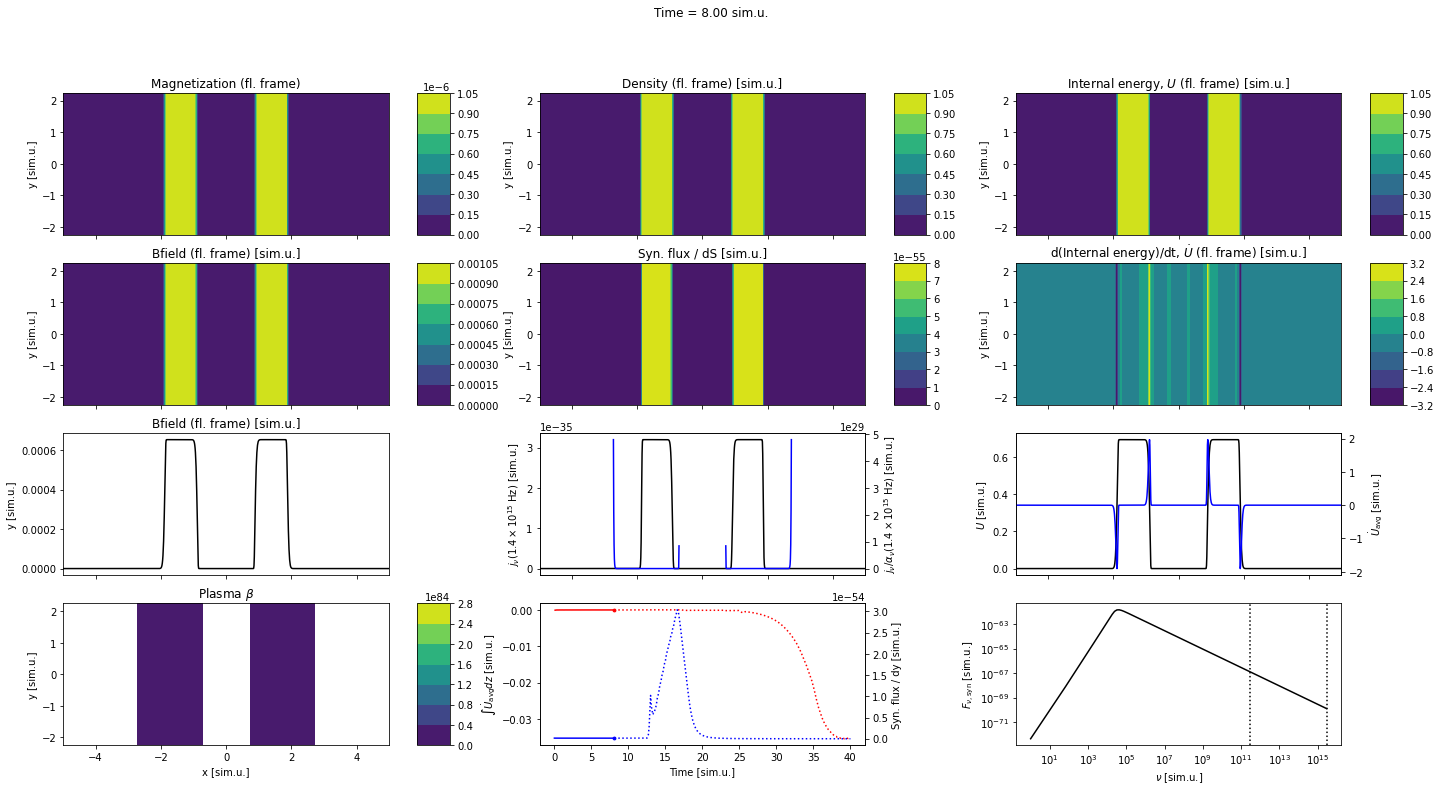

 - frame done.


In [14]:
dashboard_frame(80, save=False, history=history)